In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D

from keras.models import model_from_json
from keras.models import load_model

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.utils import shuffle
from skimage import transform
from skimage.color import rgb2gray
from skimage import io

import os
import glob



from IPython.display import clear_output

%matplotlib inline

#### Data Acquisition and Prep

The cell images used in this case are from the U.C Nation Library of Medicine. https://lhncbc.nlm.nih.gov/publication/pub9932.

Initially the Data was seperated into folders as parasitised and uninfected. Each containing 13,780 images. 
The images where not labeled so i wrote a python script to rename the images as paras.#.jpg(parasitised) or uninf.#.jpg(uninfected) i.e-

    os.rename(os.path.join(path, file), os.path.join(path, 'paras.' +str(i)+'.jpg'))
    i = i+1
    
Then I seperated the folders into train and test folders. Train containing 13,000 of each parasitised and uninifected cell images totaling 26,000 cell images. and test containing the left over 780 cell images of each folder totaling 1560 cell images. 

In [3]:
# Our training and testing folder paths
train_dir = './cell_images/train'
test_dir = './cell_images/test'

In [4]:
#figuring some stuff 
#import glob
#for img in glob.glob('cell_images/train/*.jpg'):
        #print (img.split('.')[0][-5])

### Labeling our cell images with arrays of [0,1] or [1,0] based on diagnosis.

In [5]:
# Our images now have the diagnosis in the file name. We will label our data based on the file name.
# files beginning with p are Parasitized cells
# files beginning with u are uninfected cells
# this will create our y/target variable
def label_img(img):
    word_label=img.split('.')
    if word_label[1][-5]=='p':
        return [0,1]
    elif word_label[1][-5]=='u':
        return [1,0]

### Functions to create of training and testing Data from our images

In [6]:
# A function to create training data
def mk_train_data():
    train_data = []
    num = 0
    bad = 0
    for img in glob.glob('./cell_images/train/*.jpg'):
        # Using try because out of 26,000 images one could be bad
        try:
            # Labeling the cell image as parasitized or uninfected
            label = label_img(img)
            path = os.path.join(train_dir, img)
            
            # Loading the cell image, gray scaling it then resizing to our perfered input shape
            img = io.imread(img)
            img = rgb2gray(img)
            img = transform.resize(img,[60,60])
            
            #appending each image's data and label/classification in the form of arrays
            train_data.append([np.array(img), np.array(label)])
        except:
            bad+=1
            
        num+=1
        
        if num % 1000 == 0:
            print(num)
            print(bad)
    
    shuffle(train_data)
    # Saving the data so we don't have to create it again!
    np.save('train_data.npy', train_data)
    clear_output()
    print('Finished')
    return train_data

In [7]:
# A function to create testing data/same as mk_train function
def mk_test_data():
    test_data = []
    num = 0
    bad = 0
    for img in glob.glob('./cell_images/test/*.jpg'):
        try:
            
            label = label_img(img)
            path = os.path.join(test_dir, img)
            img = io.imread(img)
            img = rgb2gray(img)
            img = transform.resize(img,[60,60])
            test_data.append([np.array(img), np.array(label)])
        except:
            bad+=1
            
        num+=1
        
        if num % 100 == 0:
            print(num)
            print(bad)
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    clear_output()
    print('Finished')
    return test_data

### The next 2 cells are used when I intially created training and testing data yet.

In [8]:
# creating train data
#train_data = mk_train_data()

In [9]:
# creating test data
#test_data = mk_test_data()

### Loading the Previously created Data.

In [10]:
# Loading in the data we previously made
train_data = np.load('./train_data.npy')
test_data = np.load('./test_data.npy')

### Creating the train and test sets.

In [11]:
X_train = np.array([i[0] for i in train_data]).reshape(-1, 60,60,1)
y_train = [i[1] for i in train_data]
y_train = np.squeeze(y_train)

X_test = np.array([i[0] for i in test_data]).reshape(-1, 60,60,1)
y_test = [i[1] for i in test_data]
y_test = np.squeeze(y_test)

In [12]:
train_data[1][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Building the model

In [13]:
# Here I'll list any model parameters
imgsize = 60
eps = 5

In [14]:
# Building the Model

cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=[imgsize,imgsize,1] ))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(32,
                    kernel_size=3,
                    activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64,
                    kernel_size=3,
                    activation ='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Flatten())
cnn_model.add(Dense(128,
                   activation='relu'))

cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2,
             activation='sigmoid'))

tensorboard = TensorBoard(log_dir='./logs',)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
cnn_model.compile(loss='binary_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])

### Loading our saved model

In [15]:
# Only if we have a trained model saved
loaded_model = load_model('cnn_model.hdf5')                 

print('Model Loaded')                 

Instructions for updating:
Use tf.cast instead.
Model Loaded


In [16]:
# Fitting ur model on our training data 

history = cnn_model.fit(x=X_train,y=y_train,
                        validation_data=(X_test,y_test),
                        callbacks=[tensorboard],
                        epochs=eps,
                        verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 25998 samples, validate on 1560 samples
Epoch 1/5
25998/25998 [==============================] - 128s 5ms/step - loss: 0.3913 - acc: 0.8124 - val_loss: 0.2696 - val_acc: 0.8849
Epoch 2/5
25998/25998 [==============================] - 116s 4ms/step - loss: 0.1940 - acc: 0.9314 - val_loss: 0.2410 - val_acc: 0.9077
Epoch 3/5
25998/25998 [==============================] - 106s 4ms/step - loss: 0.1638 - acc: 0.9426 - val_loss: 0.2352 - val_acc: 0.8987
Epoch 4/5
25998/25998 [==============================] - 116s 4ms/step - loss: 0.1544 - acc: 0.9469 - val_loss: 0.2328 - val_acc: 0.9112
Epoch 5/5
25998/25998 [==============================] - 107s 4ms/step - loss: 0.1442 - acc: 0.9503 - val_loss: 0.1999 - val_acc: 0.9170


In [17]:
# Saving our model and weights
cnn_model.save('cnn_model.hdf5',overwrite=True)
print('model saved')

model saved


## Resulting validation accuracy is 92%

In [31]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

### Here I use Matplotlib to manually check our training and testing Loss/Accuracy over our epochs

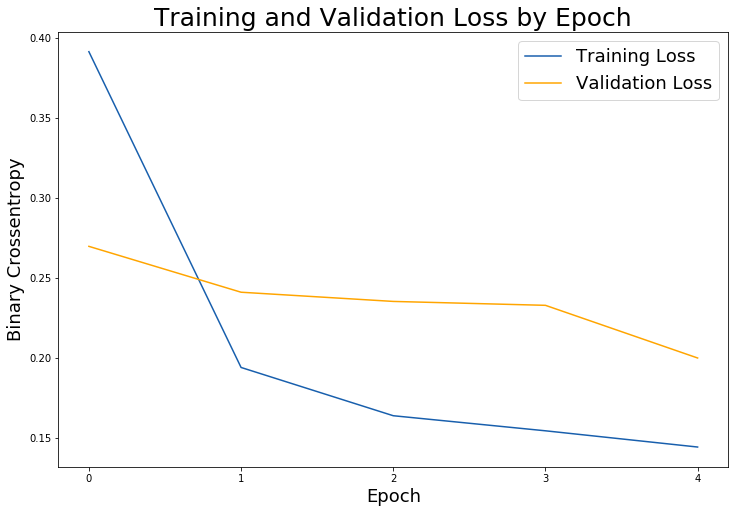

In [27]:

train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4])

plt.legend(fontsize = 18);

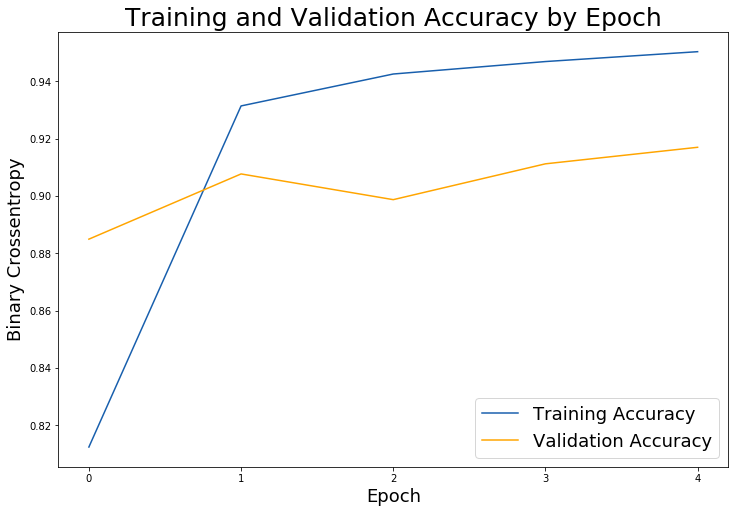

In [28]:
# Check out our accuracy 
train_loss = history.history['acc']
test_loss = history.history['val_acc']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4])

plt.legend(fontsize = 18);